<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
!pip install pandas_ta


In [141]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the data

In [142]:
# Fetch historical stock data using yfinance
ticker = 'UPWK'
start_date , end_date = '2021-01-01' , '2024-01-03'

df = yf.download(ticker, start=start_date, end= end_date)

# Calculate technical indicators (RSI, MACD, ATR, Bolinger Bands) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.ta.atr(length=14, append=True)
df.ta.bbands(append=True)

# Fetch Federal Funds Rate data from FRED
fed_funds_rate = web.DataReader("FEDFUNDS", "fred", start_date, end_date)

# Fetch Consumer Price Index (CPI) data from FRED
cpi_data = web.DataReader("CPIAUCNS", "fred", start_date, end_date)

# Fetch VIX data from Yahoo Finance using yfinance
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Rename the 'Adj Close' column to 'VIX' for consistency
vix_data = vix_data.rename(columns={'Adj Close': 'VIX'})

# Fetch Nonfarm Payrolls data from FRED using pandas_datareader
nfp_data = web.DataReader("PAYEMS", "fred", start_date, end_date)

# Rename the column to 'Nonfarm Payrolls' for consistency
nfp_data = nfp_data.rename(columns={'PAYEMS': 'Nonfarm Payrolls'})

# Ensure both DataFrames have the same frequency (daily for stock data, monthly for NFP data)
df = df.resample('D').last()
vix_data = vix_data.resample('D').last()
cpi_data = cpi_data.resample('M').last()
nfp_data = nfp_data.resample('M').last()
fed_funds_rate = fed_funds_rate.resample('M').last()


# Merge the stock_data DataFrame with the VIX data
df = pd.merge(df, vix_data['VIX'], how='left', left_index=True, right_index=True)


# Merge the stock_data DataFrame with the Federal Funds Rate data
df = pd.merge(df, fed_funds_rate, how='left', left_index=True, right_index=True)

# Forward fill the FEDFUNDS column to fill missing daily values
df['FEDFUNDS'] = df['FEDFUNDS'].ffill()

# Merge the stock_data DataFrame with the CPI data
df = pd.merge(df, cpi_data, how='left', left_index=True, right_index=True)

# Forward fill the CPIAUCNS column to fill missing daily values
df['CPIAUCNS'] = df['CPIAUCNS'].ffill()

# Merge the stock_data DataFrame with the Nonfarm Payrolls data
df = pd.merge(df, nfp_data, how='left', left_index=True, right_index=True)

# Forward fill the Nonfarm Payrolls column to fill missing daily values
df['Nonfarm Payrolls'] = df['Nonfarm Payrolls'].ffill()

# Drop rows with missing values in the index
df = df.dropna(subset=None)

df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,
2021-02-22,54.830002,56.889999,50.740002,51.430000,51.430000,3218900.0,55.777799,4.685379,-0.771146,5.456525,3.593530,50.301203,54.734000,59.166796,16.197599,0.127323,23.450001,0.09,261.582,142969.0
2021-02-23,45.810001,52.110001,43.750000,51.570000,51.570000,4322100.0,56.036244,4.230965,-0.980447,5.211413,3.963793,49.325264,53.639999,57.954735,16.087755,0.260124,23.110001,0.09,261.582,142969.0
2021-02-24,60.810001,63.880001,52.139999,53.360001,53.360001,9539200.0,59.310570,3.969519,-0.993515,4.963034,4.608105,49.711560,53.028000,56.344440,12.508261,0.550054,21.340000,0.09,261.582,142969.0
2021-02-25,52.000000,54.540001,50.419998,51.490002,51.490002,3608200.0,54.725075,3.570272,-1.114209,4.684482,4.570641,49.225772,52.772000,56.318228,13.439809,0.319245,28.889999,0.09,261.582,142969.0
2021-02-26,52.000000,55.150002,50.310001,53.880001,53.880001,2751100.0,59.079548,3.407440,-1.021633,4.429073,4.591206,50.237860,52.346001,54.454141,8.054639,0.863828,27.950001,0.09,261.582,142969.0


In [143]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 20

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATRr_14,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VIX,FEDFUNDS,CPIAUCNS,Nonfarm Payrolls
Date,,,,,,,,,,,,,,,,,,,,
2021-02-22,54.830002,56.889999,50.740002,51.430000,51.430000,3218900.0,55.777799,4.685379,-0.771146,5.456525,3.593530,50.301203,54.734000,59.166796,16.197599,0.127323,23.450001,0.09,261.582,142969.0
2021-02-23,45.810001,52.110001,43.750000,51.570000,51.570000,4322100.0,56.036244,4.230965,-0.980447,5.211413,3.963793,49.325264,53.639999,57.954735,16.087755,0.260124,23.110001,0.09,261.582,142969.0
2021-02-24,60.810001,63.880001,52.139999,53.360001,53.360001,9539200.0,59.310570,3.969519,-0.993515,4.963034,4.608105,49.711560,53.028000,56.344440,12.508261,0.550054,21.340000,0.09,261.582,142969.0
2021-02-25,52.000000,54.540001,50.419998,51.490002,51.490002,3608200.0,54.725075,3.570272,-1.114209,4.684482,4.570641,49.225772,52.772000,56.318228,13.439809,0.319245,28.889999,0.09,261.582,142969.0
2021-02-26,52.000000,55.150002,50.310001,53.880001,53.880001,2751100.0,59.079548,3.407440,-1.021633,4.429073,4.591206,50.237860,52.346001,54.454141,8.054639,0.863828,27.950001,0.09,261.582,142969.0


In [144]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ATRr_14',
       'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'VIX',
       'FEDFUNDS', 'CPIAUCNS', 'Nonfarm Payrolls'],
      dtype='object')

In [145]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
features = ['Open','Close', 'Volume', 'RSI_14','ATRr_14','VIX']
#features = ['Open', 'Close', 'Volume']
#features = ['Open','price', 'Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9', 'ATRr_14', 'VIX', 'FEDFUNDS', 'CPIAUCNS']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')

# Columns to be scaled (excluding Federal Funds Rate)
columns_to_scale = ['Open', 'Close', 'Volume', 'RSI_14', 'VIX']

train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Open,Close,Volume,RSI_14,ATRr_14,VIX
Date,,,,,,
2021-02-22,54.830002,51.430000,3218900.0,55.777799,3.593530,23.450001
2021-02-23,45.810001,51.570000,4322100.0,56.036244,3.963793,23.110001
2021-02-24,60.810001,53.360001,9539200.0,59.310570,4.608105,21.340000
2021-02-25,52.000000,51.490002,3608200.0,54.725075,4.570641,28.889999
2021-02-26,52.000000,53.880001,2751100.0,59.079548,4.591206,27.950001


### Feature Scaling

In [146]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 701



array([[0.87062436, 0.82542372, 0.12750866, 0.557052  , 0.75821316,
        0.45810756],
       [0.70786722, 0.82806025, 0.17905789, 0.56147423, 0.84624136,
        0.44393498],
       [0.97852763, 0.86177024, 0.42283736, 0.61750084, 0.99942318,
        0.37015422],
       [0.81955973, 0.82655369, 0.14569948, 0.53903896, 0.99051621,
        0.68486865],
       [0.81955973, 0.8715631 , 0.10564976, 0.61354786, 0.99540549,
        0.64568571]])

### Creating a data structure with 180 timesteps and 1 output

In [147]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [148]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [149]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (641, 60, 6)


## Part 2 - Building and Training the RNN

### Initialising the RNN

In [150]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [151]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [152]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [153]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [154]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [155]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [156]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [157]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
21/21 [==============================] - 20s 233ms/step - loss: 0.0476
Epoch 2/100
21/21 [==============================] - 6s 290ms/step - loss: 0.0089
Epoch 3/100
21/21 [==============================] - 5s 254ms/step - loss: 0.0065
Epoch 4/100
21/21 [==============================] - 2s 109ms/step - loss: 0.0071
Epoch 5/100
21/21 [==============================] - 4s 178ms/step - loss: 0.0056
Epoch 6/100
21/21 [==============================] - 2s 109ms/step - loss: 0.0057
Epoch 7/100
21/21 [==============================] - 2s 110ms/step - loss: 0.0053
Epoch 8/100
21/21 [==============================] - 2s 107ms/step - loss: 0.0053
Epoch 9/100
21/21 [==============================] - 2s 108ms/step - loss: 0.0048
Epoch 10/100
21/21 [==============================] - 3s 153ms/step - loss: 0.0045
Epoch 11/100
21/21 [==============================] - 3s 136ms/step - loss: 0.0041
Epoch 12/100
21/21 [==============================] - 2s 109ms/step - loss: 0.0048
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [158]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Open,Close,Volume,RSI_14,ATRr_14,VIX
Date,,,,,,
2023-12-04,14.19,13.97,2855900.0,58.996555,0.657973,13.08
2023-12-05,13.84,13.86,1560800.0,57.250568,0.643117,12.85
2023-12-06,14.02,13.97,1495300.0,58.570963,0.630752,12.97
2023-12-07,13.96,13.75,1056100.0,54.917561,0.614270,13.06
2023-12-08,13.64,14.06,1160400.0,58.815809,0.607536,12.35


In [159]:
# Plot a line chart using Plotly Express
fig = px.line(dataset_test, x=dataset_test.index, y='Open', title='Stock Price Over Time')

# Show the plot
fig.show()

In [160]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[14.18999958],
       [13.84000015],
       [14.02000046],
       [13.96000004],
       [13.64000034]])

In [161]:
len(dataset_test)

20

### Getting the predicted stock price

In [162]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag : ].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (80, 6)

Shape of inputs after reshaping: (80, 6)
Shape of X_test before reshaping: (20, 60, 6)

Shape of X_test after reshaping: (20, 60, 6)
1/1 [==============================] - 2s 2s/step


### Visualising the results

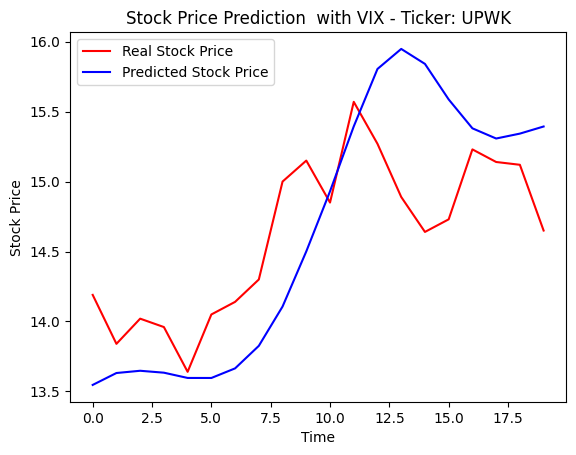

In [163]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title(f'Stock Price Prediction  with VIX - Ticker: {ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()